# CP321-ILR: MidTerm

## DMP Theory

In a DMP, the demonstrated motion with one degree of freedom (DoF) is modeled as a spring-damper system.

\begin{equation*}
    \tau^2 \ddot{x} = \alpha_x(\beta_x(g-x)-\tau\dot{x})+f
\end{equation*}

where $x$ is the state of the system, $f$ is the forcing function that determines the nonlinear behavior, $\alpha_x$ and $\beta_x$ are constants that determine the damping and spring behavior, respectively. $\tau$ is a constant that determines the temporal behavior, and $g$ denotes the goal state.

The time is modelled by a phase variable $z$ as follows:
\begin{equation*}
    \tau \dot z = -\alpha_z z
\end{equation*}
In this case, the phase variable $z$ is given by a function of time $t$
\begin{equation*}
    z(t) = z_0 \exp \left( -\frac{\alpha_z}{\tau}t \right)
\end{equation*}
Typically, the phase variable  $z \in [0, 1]$.

Using a Gaussian basis function with this phase variable $z$, the forcing function $f$ can be formulated as
\begin{equation*}
    f(z) = (g-x_0)\sum_{i=1}^M\psi_i(z)w_iz
\end{equation*}
where $x_0$ denotes the initial position and $M$ the number of the basis
functions. The Gaussian basis function $\psi_i(z)$ is given by
\begin{equation*}
    \psi_i(z) = \frac{\exp(-h_i(z-c_i)^2)}{\sum_{j=1}^M \exp(-h_j(z-c_j)^2)}
\end{equation*}
where $h_i$ and $c_i$ are constants that determine the width and centers of
the basis functions, respectively.

$\textbf{Important Note(hyperparameters):}$ While implementing the basis functions make sure that the centers of the gaussians are equally spaced in time (not in phase domain) and $h_i = M/c_i$ , $z_0=1$ , $\beta_x=\frac{\alpha_x}{4}$ , $\alpha_z = \frac{\alpha_x}{3}$ and $\alpha_x=25$.

To obtain the weight parameters in a DMP, we compute the target value of the forcing function from the given trajectory as

\begin{equation*}
    f_{\text{target}}(z(t)) = \tau^2\ddot{x}^{\text{demo}}(t)-\alpha_x(\beta_x(g-x^{\text{demo}}(t))-\tau\dot{x}^{\text{demo}}(t))
\end{equation*}

where $x^{\text{demo}}(t), \dot{x}^{\text{demo}}(t), \ddot{x}^{\text{demo}}(t)$ are the position, velocity and acceleration at the time $t$, respectively.

We can find the weight vector by minimizing the sum of the squared error.

\begin{equation*}
    L_{\text{DMP}} = \sum_{t=0}^{T}(f_{\text{target}}(z(t))-f(z(t)))^2
\end{equation*}

by solving the least squares solution we get

\begin{equation*}
    w = (\Phi^\top \Phi)^{-1}\Phi^\top F
\end{equation*}

where $\Phi_{i,j} = \psi_j(z(t_i))*z(t_i)$ and

\begin{equation*}
    F = \left[ \frac{f_{\text{target}}(0)}{(g-x_0)},\cdots,\frac{f_{\text{target}}(t)}{(g-x_0)},\cdots,\frac{f_{\text{target}}(T)}{(g-x_0)} \right]
\end{equation*}

$\textbf{Important Note(dimensionality):}$ Since DMPs are primarily designed
for learning a motion for a single degree of freedom, multiple DMPs
need to be learned for each dimension when learning motions with multiple dimensions.

In [283]:
%reload_ext autoreload
%autoreload 2

from functools import partial

import matplotlib.pyplot as plt
import numpy as np
from numpy.typing import NDArray
from utils.lasa import load_lasa
from utils.models import DMP, BaseModelABC


In [284]:
# HELPER FUNCTIONS


def plot_curves(x, show_start_end=True, **kwargs):
    """
    plots 2d curves of trajectories

    params:
        x: array of shape (number of curves,n_steps_per_curve,2)
    """
    if show_start_end:
        start_label, end_label = "start", "end"
    else:
        start_label, end_label = None, None
    for t in range(x.shape[0]):
        plt.scatter(x[t][0, 0], x[t][0, 1], c="k", label=start_label)
        plt.scatter(x[t][-1, 0], x[t][-1, 1], c="b", label=end_label)
        plt.plot(x[t][:, 0], x[t][:, 1], **kwargs)
        if t == 0:
            kwargs.pop("label", None)
            start_label, end_label = None, None

    plt.legend()


def streamplot(f, x_axis=(0, 100), y_axis=(0, 100), n=1000, width=1, **kwargs):
    """
    helps visualizing the vector field.

    params:
        f: function to predict the velocities in DS(Dynamical system : x_dot = f(x),x of shape (n_points,2),x_dot of shape (n_points,2))
        x_axis: x axis limits
        y_axis: y axis limits
        n: number of points in each axis (so total n*n predictions happen)
        width: width of the vector
        **kwargs: goes into plt.streamplot
    """
    a, b = np.linspace(x_axis[0], x_axis[1], n), np.linspace(y_axis[0], y_axis[1], n)
    X, Y = np.meshgrid(a, b)
    X_test = np.stack([X, Y], axis=-1).reshape(-1, 2)
    Y_pred = f(X_test)
    U, V = np.split(Y_pred.reshape(n, n, 2), 2, axis=-1)
    U, V = U[..., 0], V[..., 0]
    speed = np.sqrt(U**2 + V**2)
    lw = width * speed / speed.max()
    plt.streamplot(X, Y, U, V, linewidth=lw, **kwargs)


# loading the data and plotting
def load_data(letter):
    """
    gets the trajectories coresponding to the given letter

    params:
        letter: character in ["c","j","s"]

    returns:
        data: array of shape (number of trajectories,number of timesteps,2)
        x: array of shape(number of trajectories*number of timesteps,2)
        xd: array of shape(number of trajectories*number of timesteps,2)

    """
    letter2id = dict(c=2, j=6, s=24)
    assert letter.lower() in letter2id
    _, data, _, _, _, _ = load_lasa(letter2id[letter.lower()])
    return data

In [285]:
data = load_data("s")

# 1Q. Plot all the trajectories (10 Marks)

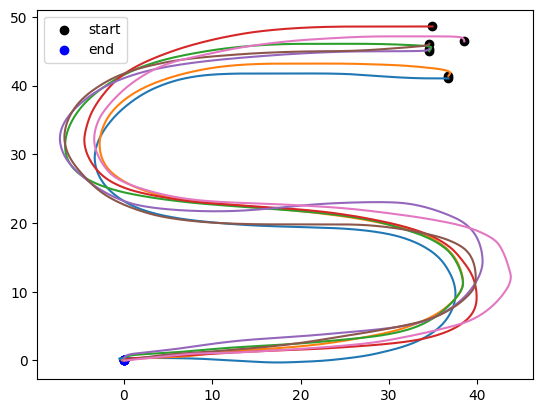

In [286]:
################################
plot_curves(data)
################################

In [287]:
# get a single trajectory from data
x = data[0]
x0, g = x[0], x[-1]

# 2Q. DMP Implemetation (50 Marks)

Please fill the code in the 'YOUR CODE HERE' section.

Information about the hyperparameters and theory is given in the question paper

In [288]:
class DMP(BaseModelABC):
    def __init__(self, alpha: float, n_features: int):
        """
        set the hyperparameters
        """
        # set the hyperparameters from the inputs
        # self.alpha,self.beta,self.alpha_z,self.n_features
        # information about the values of the parameters is given in the theory part

        self.alpha = alpha
        self.beta = self.alpha / 4.0
        self.alpha_z = self.alpha / 3.0
        self.n_features = n_features

    def derivative(self, x: NDArray) -> NDArray:
        """
        difference method for calculating derivative

        params:
            x: array of shape (number of trajectories,number of timesteps,2)

        returns
            xd: array of shape (number of trajectories,number of timesteps,2)
        """
        T, ndims = x.shape
        return np.vstack((np.zeros((1, ndims)), np.diff(x, axis=0) / self._dt))

    def get_features(self, z: NDArray, cz: NDArray, hz: NDArray) -> NDArray:
        """
        Returns the PSI matrix as given in the theory part

        input:
            z : array of shape (n_steps,)
            cz: centers of gaussian in phase domain ,array of shape(n_features,)
            hz: scaling factor for each of the gaussian ,array of shape (n_features,)
        returns:
            features: array of shape (n_steps,n_features)
        """
        ################################
        psi = np.exp(-hz * (z[:, None] - cz[None, :]) ** 2)
        return psi / np.sum(psi, axis=1, keepdims=True)
        ################################

    def fit(self, x: NDArray):
        """
        learn the weight vector from LeastSquares,store the weight vectors in self.w (array of shape

        input
            x: trajectory data (n_steps,2)
        """

        # set x0 (starting point) , g(goal point) in self.x0,self.g respectively.
        # assumption is that g(goal point) is the end of the trajectory , and x0 is the start of the trajectory
        # self.x (array of shape (n_steps,2) , self.x0 (array of shape (2,)) , self.g (array of shape (2,))
        ################################
        self.x = x
        self.x0 = x[0]
        self.g = x[-1]
        ################################

        self.T_train = 1.0
        self._dt = self.T_train / (x.shape[0] - 1)

        # get the speed and acceleration using self.derivative method and store it in self.xd,self.xdd
        # self.xd (array of shape (n_steps,2)),self.xdd (array of shape (n_steps,2))
        ################################
        self.xd = self.derivative(x)
        self.xdd = self.derivative(self.xd)
        ################################

        # calulate f_target as mentioned in the theory part and store in "f_target" variable
        # f_target (array of shape (n_steps,2))
        ################################
        f_target = (self.T_train**2) * self.xdd - self.alpha * (
            self.beta * (self.g - x) - self.T_train * self.xd
        )
        ################################

        # set the centers,scaling for basis functions in self.cz,self.hz variables (Note that equal spacing in time domain ,not in phase domain)
        # information about self.hz  (scaling parameter) is given in the theory part
        # self.cz (array of shape (n_features,)),self.hz (array of shape(n_features,))
        ################################
        self.cz = np.linspace(0, self.T_train, self.n_features)
        self.hz = self.n_features / (self.cz + 1e-8)
        ################################

        t = np.linspace(0, self.T_train, x.shape[0])
        z = np.exp(-self.alpha_z * t / self.T_train)
        # store the feature matrix in "feature" variable, use the get_features method.
        # features (array of shape (n_steps,n_features))
        ################################
        features = self.get_features(z, self.cz, self.hz)
        ################################

        # get the weight vectors using leastsquares(can also use np.linalg.pinv) and store in self.w
        # self.w (array of shape (n_features,2))
        ################################
        F: NDArray = f_target / (self.g - self.x0)
        # self.w = np.linalg.pinv(features) @ F
        self.w = np.linalg.lstsq(features * z[:, None], F, rcond=None)[0]
        ################################

    def predict(self, X):
        """For backwards compatibility with BaseModelABC"""
        raise NotImplementedError

    def f_external(self, z):
        """
        once we have the weight vector,get the control function.

        input:
            z: float (phase variable)
        output
            f_ext: array of shape (2,) (for both x1,x2)
        """
        cz = self.cz
        hz = self.hz
        # here cz is the centers of the gaussians, hz are the scaling factors
        # forcing function definition given in the theory part
        ################################
        psi = np.exp(-hz * (z - cz) ** 2)
        psi /= np.sum(psi)
        return (self.g - self.x0) * np.dot(psi, self.w) * z
        ################################

    def ode_differential(self, x, t, f_ext):
        """spring-mass dynamcis
        used for rk4 simulation later ,f_ext is function of z

        input :
            x : array of shape (5,) where 5 dimension where x is x1,x2,x1_dot,x2_dot,z
            t : float >=0.0 (dummy parameter , you will not be using this)
            f_ext : function that takes z as input and returns 2 dimensional array (control forces for x1,x2)
        output: array of shape (5,) where 5 dimension where x is x1_dot,x2_dot,x1_dot_dot,x2_dot_dot,z_dot
        """
        alpha, beta, alpha_z, tau = self.alpha, self.beta, self.alpha_z, self.tau
        # Use the above hyperparameters for dynamical system
        ################################
        x1, x2, x1_dot, x2_dot, z = x
        f = f_ext(z)
        x_ddot = (
            alpha
            * (beta * (self.g - np.array([x1, x2])) - tau * np.array([x1_dot, x2_dot]))
            + f
        )
        z_dot = -alpha_z * z / tau
        return np.array(
            [x1_dot, x2_dot, x_ddot[0] / self.tau**2, x_ddot[1] / self.tau**2, z_dot]
        )
        ################################

    def imitate(self, x0=None, g=None, tau=1.0):
        """
        after learning , we can change the starting position and the ending position for imitation,
        temporal variation is done by tau
        """
        if x0 is not None:
            self.x0 = x0
        if g is not None:
            self.g = g
        self.tau = tau

        # function to use for controller
        f_ext = self.f_external

        # dynamics function
        f_diff = partial(self.ode_differential, f_ext=f_ext)

        # inital point with zero velocity,zeros acceleration
        x_initial = np.array([self.x0[0], self.x0[1], 0.0, 0.0, 1.0])

        # rk4 simulation, till convergence
        x_rk4, t_rk4 = self.rk4_sim(0, x_initial, f_diff)

        # plotting
        plt.plot(x_rk4[:, 0], x_rk4[:, 1], label="dmp")
        plt.plot(self.x[:, 0], self.x[:, 1], label="original")
        plt.legend()
        plt.show()

    def rk4_sim(self, t0, x0, f, dt=1e-3, max_iter=1e5):
        """
        simlution done with rk4

        Returns
        -------
        x : shape (n_steps,5)
        t : shape - (n_steps,)
        """

        # Calculate slopes
        x, t = x0, t0
        x_list, t_list = [x0], [t0]
        i = 0
        while np.linalg.norm(x[:2] - self.g) > 5e-1:
            k1 = dt * f(x, t)
            k2 = dt * f(x + k1 / 2.0, t + dt / 2.0)
            k3 = dt * f(x + k2 / 2.0, t + dt / 2.0)
            k4 = dt * f(x + k3, t + dt)

            # Calculate new x and y
            x = x + 1.0 / 6 * (k1 + 2 * k2 + 2 * k3 + k4)
            t = t + dt
            x_list.append(x)
            t_list.append(t)
            i += 1
            if i >= max_iter:
                print("MAX ITER REACHED : taking too long to converge")
                print(f"simulated for {t} seconds")
                return
        print(f"Took {t} seconds to reach the goal")

        return np.array(x_list), np.array(t_list)

In [289]:
# train the dmp model
alpha = 25
n_features = 10
dmp = DMP(alpha, n_features)
dmp.fit(x)

Took 1.0289999999999975 seconds to reach the goal


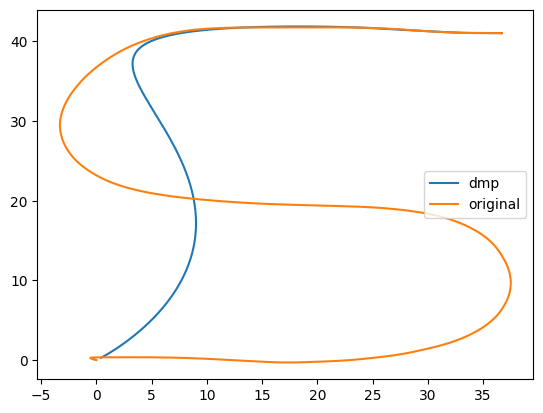

In [290]:
# imitation for training configuration
x0, g = x[0], x[-1]
tau = 1.0
dmp.imitate(x0, g, tau)

# 3Q. Spatial variation (15 Marks)

Try 5 different configurations of starting and goal positions and plot the generated trajectories. Comment on the generalization and stability.

Imitating from [35.4604665  45.54162782] to [2.31993942 0.98658484]
Took 1.024999999999998 seconds to reach the goal


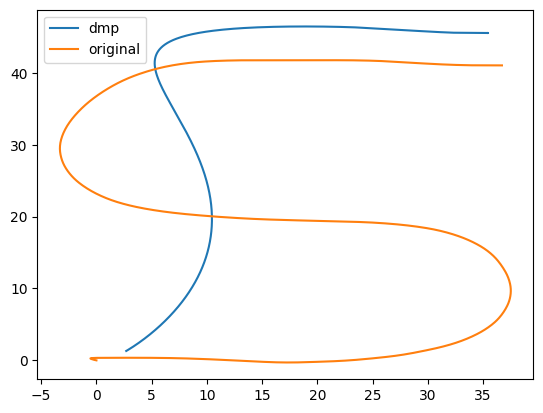

Imitating from [33.27525171 37.59442996] to [-4.41916388  3.66176146]
Took 1.023999999999998 seconds to reach the goal


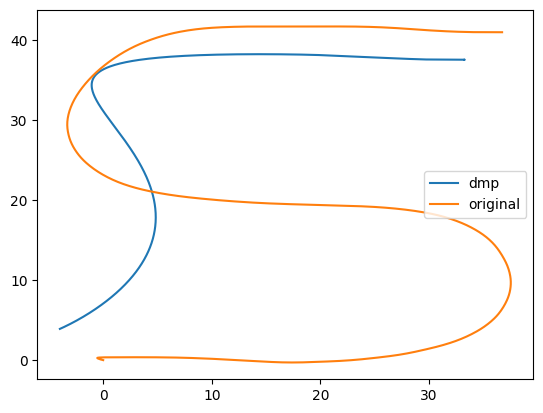

Imitating from [37.72621542 43.11521053] to [-4.79415506  4.69909852]
Took 1.0399999999999963 seconds to reach the goal


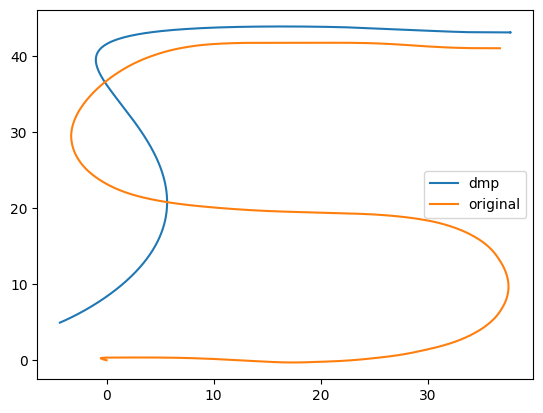

Imitating from [40.03949172 38.15787586] to [-3.18175033 -3.1659549 ]
Took 1.0439999999999958 seconds to reach the goal


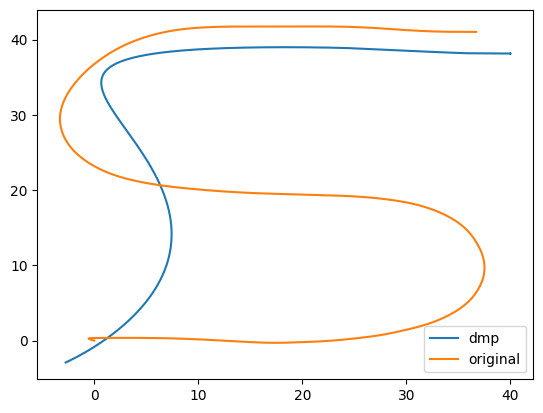

Imitating from [34.75748774 41.28204907] to [-0.68054981 -2.0877086 ]
Took 1.0279999999999976 seconds to reach the goal


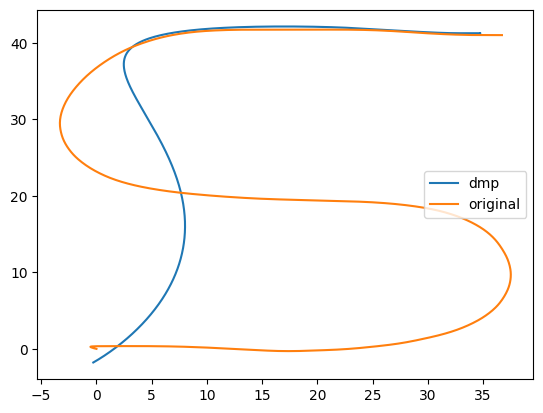

In [291]:
################################
np.random.seed(42)
_dr = lambda: np.random.uniform(-5, 5, size=(2,))
tau = 1.0
for i in range(5):
    new_x0 = x0 + _dr()
    new_g = g + _dr()
    print(f"Imitating from {new_x0} to {new_g}")
    dmp.imitate(new_x0, new_g, tau)
################################

## Stability

For the multiple trajectories above, we can see that the trajectories converge similarly to the goal position.

Thereby, in general, the trajectories are stable.

Can check from the vector field too.

## Generalisation

As seen from the graphs, changing the initial and final positions does not affect the trajectory much.

The trajectory is stable and follows a similar path.

# 4Q. Temporal variation (15 Marks)

From the training configuration($\textbf{x0}=x[0],\textbf{g}=x[-1]$), try $5$ different $\tau \gt 0$ (temporal parameter in the algorithm), some greater than 1 and some less than 1. Note down the approximate time taken for the generated trajectories to converge. Comment on the effect of temporal parameter.


Imitating with tau=0.5
Took 0.5150000000000003 seconds to reach the goal


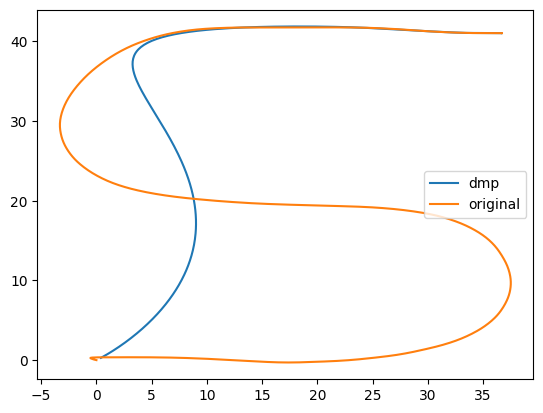

Imitating with tau=0.8
Took 0.8230000000000006 seconds to reach the goal


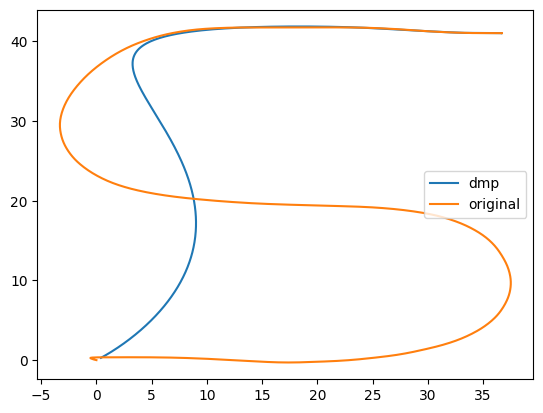

Imitating with tau=1.0
Took 1.0289999999999975 seconds to reach the goal


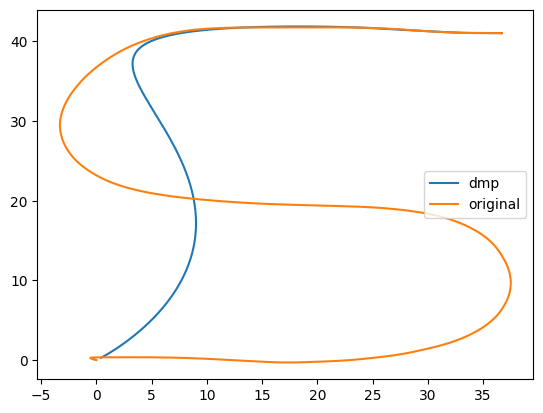

Imitating with tau=1.2
Took 1.233999999999975 seconds to reach the goal


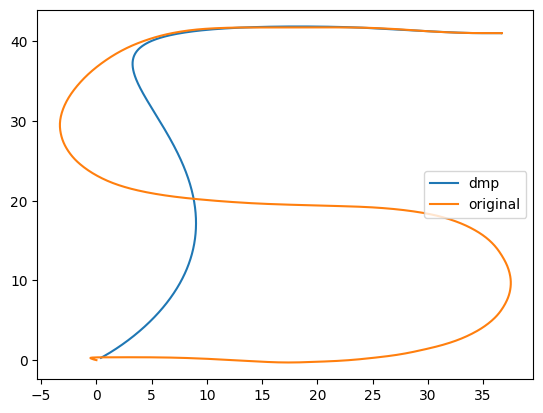

Imitating with tau=1.5
Took 1.5429999999999409 seconds to reach the goal


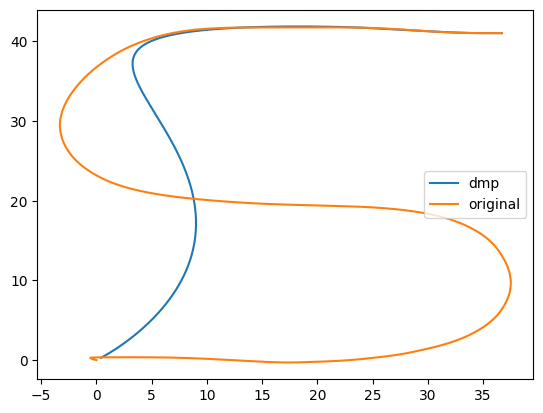

In [292]:
################################
for tau in [0.5, 0.8, 1.0, 1.2, 1.5]:
    print(f"Imitating with tau={tau}")
    dmp.imitate(x[0], x[-1], tau=tau)
################################

## Effect of temporal parameter

As seen from the graphs, changing the temporal parameter does not affect the trajectory much.

The time taken to converge changes slightly, and increaseses with increase in $\tau$.

# 5Q.

Discuss and compare the following methods in the context of dynamic movement primitives (DMPs): DMP, SEDS, ProMP, TP-GMM, and TP-GPT. In your answer, analyze how each method addresses two key aspects:

Stability: How does the method ensure convergence or robustness in generating movements?

Generalization: How effectively does the method adapt to variations or new conditions beyond the training demonstrations?

Present your analysis in a table format with the rows representing each method (DMP, SEDS, ProMP, TP-GMM, TP-GPT) and the columns for Stability and Generalization. Be sure to critically evaluate the strengths and weaknesses of each approach in these dimensions.. (10 Marks)

| Method                                                   | Stability                                                                                                                                         | Generalization                                                                                                                                                                                                |
|----------------------------------------------------------|---------------------------------------------------------------------------------------------------------------------------------------------------|---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| DMP: Dynamic Movement Primitives                         | Ensures stability using an attractor-based system (spring-damper dynamics). The phase variable helps regulate temporal evolution.                 | Generalizes well to new start and goal positions by modifying initial and final conditions. However, generalization to significantly different trajectories requires additional adaptation, as seen in ProMP. |
| SEDS: Stable Estimator of Dynamical Systems              | Guarantees global stability by the Lyapunov stability constraints, ensuring trajectories converge to the goal.                                    | Learns stable vector fields but struggles with highly variable motions. The generalization is limited, in the sense that, the trajectories follow only the learned vector field.                              |
| ProMP: Probabilistic Movement Primitives                 | Here, the stability depends on trajectory distributions rather than explicit constraints. Lacks explicit convergence guarantees like in DMP.      | Very good generalization due to modeling trajectory distributions probabilistically. Can adapt well to new task conditions, and advantageous by returning uncertainty estimations too.                        |
| TP-GMM: Task-Parameterized Gaussian Mixture Model        | Uses a (Gaussian) mixture model for trajectory encoding. Stability depends on how well constraints are learned from demonstrations.               | Very good generalization capability. Requires careful tuning of mixture components. Also, computational cost can be high ($\sim O(n^3)$).                                                                     |
| TP-GPT: Task-Parameterized Gaussian Process Trajectories | Stability depends on the Gaussian process regression properties and the underlying kernel function. Not explicitly constrained like DMPs or SEDS. | Very good generalization through task parameters and nonparametric regression.                                                                                                                                |